<font  style="font-size: 3rem; color: darkviolet"> Neural Networks in TensorFlow </font>

AA - DEL - 2023/24 - TP1 - 3h

Author: Francesca Galassi

*This assignment is inspired by the Deep Learning course on Coursera by Andrew Ng, Stanford University, for which we are thankful.*

**Submit this notebook with your solutions, answers and observations.**

In this practical, you will learn how to use TensorFlow, a powerful framework that simplifies the creation and training of neural networks. TensorFlow, along with other tools like Torch, can significantly accelerate your progress in deep learning development.

You'll explore a dataset, preprocess it, initialize network parameters, and build and train a neural network using TensorFlow. The task involves multi-class classification, where the goal is to classify inputs into one of several possible categories.

Resources to understand and work with gradients in TensorFlow:

Introduction to Gradients and Automatic Differentiation: 
https://www.tensorflow.org/guide/autodiff 

GradientTape documentation:
https://www.tensorflow.org/api_docs/python/tf/GradientTape


### Table of Contents
- [1 - Dataset](#1)
- [2 - One Hot Encoding](#2)
- [3 - Parameters Initialization](#3)
- [4 - Building a Neural Network in TensorFlow](#4)
    - [4.1 - Forward Propagation](#4.1)
    - [4.2 - Total Loss](#4.2)
    - [4.3 - Training the Model](#4.3)

In [1]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time

Matplotlib is building the font cache; this may take a moment.


You will be using v2.x, for maximum speed and efficiency.

In [2]:
tf.__version__

'2.19.0'

<a name='1'></a>
## <font color='darkviolet'> 1 - Dataset

The `tf.Tensor` object is a fundamental data structure in TensorFlow used for manipulating and storing numerical data. Tensors are similar to NumPy arrays, as they are multidimensional arrays with specific data types and contain information about the computational graph.
    
Using TensorFlow datasets created from HDF5 files offers advantages in terms of efficiency and scalability. It is a more efficient alternative to using NumPy arrays for storing large datasets, as it enables you to work with streaming data.

In [3]:
# Open the HDF5 files
train_dataset = h5py.File('data/train_signs.h5', "r")
test_dataset = h5py.File('data/test_signs.h5', "r")

# Create datasets from HDF5 datasets
x_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_x'])
y_train = tf.data.Dataset.from_tensor_slices(train_dataset['train_set_y'])

x_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_x'])
y_test = tf.data.Dataset.from_tensor_slices(test_dataset['test_set_y'])

#### <font color='blue'>  Exercise 1. 

Exploring and describing the dataset is a fundamental initial task in any deep learning project. Use the code and steps provided below to explore and describe the dataset. Use appropriate TensorFlow methods or attributes to determine information about the dataset, including shape, data type, and the number of unique classes or labels. Preprocess the data as indicated.
    
In TensorFlow, datasets are designed as iterable data sources. You typically iterate over them using a for loop or explicitly create a Python iterator using `iter` and consume its elements using `next`. In addition, you can examine the `shape` and `dtype` of each element in the dataset using the `element_spec` attribute.

TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)
{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)}


2025-07-18 00:10:34.967875: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


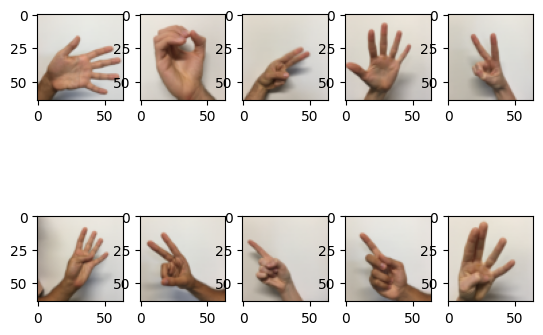

In [4]:
# Examine the shape and data type of the elements using the element_spec attribute.
# TODO
print(x_train.element_spec)

# Examine labels
unique_labels = set()
for element in y_train:
    unique_labels.add(element.numpy())
print(unique_labels)

# Iterate over the dataset to display the first 10 images and labels
# TODO
i=1
for element in x_train:
    plt.subplot(2,5,i)
    plt.imshow(element)
    i+=1
    if (i>10):
        break

Normalization is a crucial preprocessing step that can improve training and convergence of deep neural network. By scaling pixel values to a consistent range, normalization ensures that the model's optimization algorithms operate effectively.

The `normalize` function performs this preprocessing on an image tensor. It first converts the data type of the tensor if needed, then normalizes the pixel values to a standard scale. Finally, it flattens the tensor into a 1D representation, which is more convenient for subsequent processing by the neural network.

In [5]:
def normalize(image):

    # Convert the data type of the input image to float32 and normalize its components
    image = tf.cast(image, tf.float32) / 255.0
    
    # Reshape the image tensor into a 1D vector
    image = tf.reshape(image, [-1,])
    
    return image

In TensorFlow datasets, the `map()` method enables you to apply a function to each element within the dataset. This function can be customized to perform any desired operation or transformation on the dataset elements.

In [6]:
# Apply normalization to each image in the dataset
#TODO
new_x_train = x_train.map(normalize)
new_x_test = x_test.map(normalize)

<a name='2'></a>
## <font color='darkviolet'> 2 - One Hot Encoding

In deep learning, we often represent labels as vectors ranging from $0$ to $C-1$, where $C$ is the number of classes. To work with these labels effectively, we use "one-hot encoding". This technique converts class labels into numerical vectors, making them compatible with machine learning models and facilitating interpretation of model predictions.
    
Each class is represented by a vector where only one element (the one corresponding to the class) is "hot" (set to 1), while all other elements are "cold" (set to 0). 
    
For example, for $C=4$, the labels vector might be:

<img src="data/one_hot.png" style="width:600px;height:150px;">
    
In TensorFlow, you can easily perform one-hot encoding using the `tf.one_hot()` function. This function takes the labels and the total number of classes (`depth`) as input and returns a one-hot encoded representation of the labels.
    
`tf.one_hot(labels, depth, axis=0)`https://www.tensorflow.org/api_docs/python/tf/one_hot
   
<a name='ex-2'></a>
#### <font color='blue'> Exercise 2.
    
The function `one_hot_matrix` takes a single label and the total number of classes `depth` as input and returns the one-hot encoding as a single-row matrix. It first uses `tf.one_hot()` to generate the one-hot encoding for the label and then reshapes the tensor to have a single row, flattening it using `tf.reshape()`.

In [7]:
def one_hot_matrix(label, depth=6):
    """
    Computes the one-hot encoding for a single label.

    Arguments:
        label -- (int) Categorical label.
        depth -- (int) Number of different classes that label can take.

    Returns:
         one_hot -- tf.Tensor A single-row matrix with the one-hot encoding.
    """
    # Use the built-in TensorFlow function tf.one_hot to compute the one-hot encoding for the label.
    # TODO
    encoded = tf.one_hot(label,depth=depth)
    
    # Reshape the tensor to have a single row and flatten it.
    # TODO
    one_hot = tf.reshape(encoded,[depth])
    
    return one_hot

In [8]:
def one_hot_matrix_test(target):
    label = tf.constant(1)
    depth = 4
    result = target(label, depth)
    print("Test 1:",result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 1. ,0., 0.] ), "Wrong output. Use tf.one_hot"
    label_2 = [2]
    result = target(label_2, depth)
    print("Test 2:", result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 0. ,1., 0.] ), "Wrong output. Use tf.reshape as instructed"
    
    print("\033[92mAll test passed")

one_hot_matrix_test(one_hot_matrix)

Test 1: tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
Test 2: tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
All test passed


Use the `map()` method in TensorFlow datasets to apply the `one_hot_matrix()` function to each element in `y_test` and `y_train`, thereby creating new datasets `new_y_test` and `new_y_train` containing the one-hot encoded labels.

In [9]:
# One-hot encoding
# TODO

new_y_test  = y_test.map(one_hot_matrix)
new_y_train = y_train.map(one_hot_matrix)

<a name='3'></a>
## <font color='darkviolet'> 3 - Parameters Initialization
  
Using an appropriate initializer, like the Glorot initializer, helps ensure that the neural network starts training from a good initialization point. This leads to more effective and efficient learning, as the optimization algorithm can converge faster and more reliably to a good solution.
    
In this step, you will initialize the neural network model parameters using the Glorot initializer, which can be accessed through `tf.keras.initializers.GlorotNormal`.
It creates values from a normal distribution centered at 0, with a standard deviation of `sqrt(2 / (fan_in + fan_out))`. Here, `fan_in` represents the number of input units, and `fan_out` represents the number of output units in the weight tensor.

<a name='ex-3'></a>
#### <font color='blue'> Exercise 3.

Complete the function using:

 - `tf.keras.initializers.GlorotNormal(seed=1)`
 - `tf.Variable(initializer(shape=())`

In [10]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are given:
    
                        W1 : [25, 12288]  --> [hidden layer size, input size]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
                                
    initializer = tf.keras.initializers.GlorotNormal(seed=1)
    
    # Initialize parameters for each layer of the neural network
    # TODO

    W1 = tf.Variable(initializer(shape=(25,12288)))
    b1 = tf.Variable(initializer(shape=(25,1)))
    W2 = tf.Variable(initializer(shape=(12,25)))
    b2 = tf.Variable(initializer(shape=(12,1)))
    W3 = tf.Variable(initializer(shape=(6,12)))
    b3 = tf.Variable(initializer(shape=(6,1)))

    # Dictionary
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters


In [11]:
def initialize_parameters_test(target):
    parameters = target()

    values = {"W1": (25, 12288),
              "b1": (25, 1),
              "W2": (12, 25),
              "b2": (12, 1),
              "W3": (6, 12),
              "b3": (6, 1)}

    for key in parameters:
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        assert type(parameters[key]) == ResourceVariable, "All parameter must be created using tf.Variable"
        assert tuple(parameters[key].shape) == values[key], f"{key}: wrong shape"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5,  f"{key}: Use the GlorotNormal initializer"
        assert np.std(parameters[key].numpy()) > 0 and np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    print("\033[92mAll test passed")

initialize_parameters_test(initialize_parameters)

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
All test passed


<a name='4'></a>
## <font color='darkviolet'> 4 - Building a Neural Network in TensorFlow

In this section, you will build a neural network. This process involves two major steps: i) implementing forward propagation and ii) retrieving the gradients.

<a name='4.1'></a>
### <font color='darkviolet'> 4.1 - Forward Propagation 

TensorFlow simplifies neural network construction by automatically tracking operations for backpropagation. You only need to implement the forward propagation function, and it will keep track of the operations you did to calculate the back propagation automatically.  

<a name='ex-4'></a>
#### <font color='blue'> Exercise 4.1.

Complete the `forward_propagation` function using:
- `tf.math.add`
- `tf.linalg.matmul`
- `tf.keras.activations.relu`
    
Then, explain the role of the ReLU activation function in a neural network.

Bonus: What Numpy functions are equivalent to the operations performed in the `TODO` lines of the `forward_propagation` function?

In [12]:
def forward_propagation(X, parameters):
    """
    Implements forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    Args:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- dictionary containing the parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # Implement forward propagation
    # TODO

    c1 = tf.linalg.matmul(W1,X)
    d1 = tf.math.add(c1,b1)
    Z1 = tf.keras.activations.relu(d1) 

    c2 = tf.linalg.matmul(W2,Z1)
    d2 = tf.math.add(c2,b2)
    Z2 = tf.keras.activations.relu(d2) 

    c3 = tf.linalg.matmul(W3,Z2)
    d3 = tf.math.add(c3,b3)

    return d3

In [13]:
def forward_propagation_test(target, examples):
    minibatches = examples.batch(2)
    parametersk = initialize_parameters()
    W1 = parametersk['W1']
    b1 = parametersk['b1']
    W2 = parametersk['W2']
    b2 = parametersk['b2']
    W3 = parametersk['W3']
    b3 = parametersk['b3']
    index = 0
    minibatch = list(minibatches)[0]
    with tf.GradientTape() as tape:
        forward_pass = target(tf.transpose(minibatch), parametersk)
        print(forward_pass)
        fake_cost = tf.reduce_mean(forward_pass - np.ones((6,2)))

        assert type(forward_pass) == EagerTensor, "Your output is not a tensor"
        assert forward_pass.shape == (6, 2), "Last layer must use W3 and b3"
        assert np.allclose(forward_pass, 
                           [[-0.13430887,  0.14086473],
                            [ 0.21588647, -0.02582335],
                            [ 0.7059658,   0.6484556 ],
                            [-1.1260961,  -0.9329492 ],
                            [-0.20181894, -0.3382722 ],
                            [ 0.9558965,   0.94167566]]), "Output does not match"
    index = index + 1
    trainable_variables = [W1, b1, W2, b2, W3, b3]
    grads = tape.gradient(fake_cost, trainable_variables)
    assert not(None in grads), "Wrong gradients. It could be due to the use of tf.Variable whithin forward_propagation"
    print("\033[92mAll test passed")

forward_propagation_test(forward_propagation, new_x_train)

tf.Tensor(
[[-0.13430887  0.14086476]
 [ 0.21588647 -0.02582344]
 [ 0.7059659   0.6484557 ]
 [-1.1260965  -0.9329492 ]
 [-0.20181876 -0.33827227]
 [ 0.9558964   0.9416754 ]], shape=(6, 2), dtype=float32)
All test passed


2025-07-18 00:10:35.552560: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<a name='4.2'></a>
### <font color='darkviolet'> 4.2 - Total Loss

In this multi-class classification problem, you will use categorical cross-entropy as the loss function. It measures the dissimilarity between predicted class probabilities and true labels, with predicted probabilities generated using the softmax function. This function takes a vector of arbitrary real-valued scores (often called logits) as input and converts them into a probability distribution across multiple classes. The softmax output is a vector where each element denotes the probability of the corresponding class.
   
During training, the total loss will be used to adjust the model's parameters via backpropagation. Indeed, when handling mini-batches of data during training, opting for the total loss over the average loss ensures consistency in assessing the model's performance. For example, if you have 5 samples but process 4 at a time, the last mini-batch will have only 1 sample. By using the total loss, you ensure that each sample contributes equally to the overall evaluation, leading to consistent training outcomes.

<a name='ex-5'></a>
#### <font color='blue'> Exercise 4.2.
    
Implement the total loss function using:
    
- `tf.nn.softmax_cross_entropy_with_logits`

- `tf.reduce_sum`

In [50]:
def compute_total_loss(logits, labels):
    """
    Computes the total loss.

    Arguments:
    logits -- the output of forward propagation (the output of the last LINEAR unit), of shape (num_examples, num_classes)
    labels -- the "true" labels vector, of the same shape as logits

    Returns:
    total_loss -- a Tensor representing the total loss value   
    """
    # Compute the individual losses.    
    # TODO -  axis: the class dimension. 
    indiv = tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits,axis=0)
    # Compute the total loss as the sum of the individual losses.
    # TODO
    total_loss = tf.reduce_sum(indiv)
    return total_loss

In [51]:
def compute_total_loss_test(target, Y):
    # Tensor with predicted values. 
    # Note: the shape of pred is (num_classes, num_examples). 6 classes and 2 examples.
    pred = tf.constant([[ 2.4048107,   5.0334096 ],
             [-0.7921977,  -4.1523376 ],
             [ 0.9447198,  -0.46802214],
             [ 1.158121,    3.9810789 ],
             [ 4.768706,    2.3220146 ],
             [ 6.1481323,   3.909829  ]])
    
    #print(f"pred shape: {pred.shape}")
    
    # A batch size of 2
    minibatches = Y.batch(2)
    for minibatch in minibatches:
        
        print(f"Minibatch shape: {tf.transpose(minibatch)}")
        # Note: transposes the minibatch to match the shape of the predicted values.
        result = target(pred, tf.transpose(minibatch))
        break
        
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    assert (np.abs(result - (0.50722074 + 1.1133534) / 2.0) < 1e-7), "Test does not match. Did you get the reduce sum of your loss functions?"

    print("\033[92mAll test passed")

compute_total_loss_test(compute_total_loss, new_y_train)

Minibatch shape: [[0. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]]
All test passed


<a name='4.3'></a>
### <font color='darkviolet'> 4.3 - Training the Model

When training a model, you need to use an optimizer to update the parameters and improve its accuracy. You can specify the optimizer, such as `tf.keras.optimizers.Adam`, in just one line of code. There are other optimizers available, like Stochastic Gradient Descent.

Next, you'll use `tape.gradient` to calculate the gradients of the loss function with respect to the model's parameters. Then, you'll use the optimizer's `apply_gradients` method to update the model's parameters using the calculated gradients.

An additional step has been added to the batch training process: `dataset = dataset.prefetch(8)`. This step helps prevent a memory bottleneck that can occur when reading data from disk. By prefetching the data, it's kept ready for when it's needed and processed in smaller, more manageable pieces to improve efficiency.
    
<a name='ex-6'></a>
#### <font color='blue'> Exercise 4.3.
    
Complete the code as indicated. Then, observe and describe the learning curves on both training and test datasets. 

In [52]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
          num_epochs=1500, minibatch_size=32, print_cost=True):
    """
    Implements a three-layer TensorFlow neural network: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (number of training examples, input size)
    Y_train -- training labels, of shape (number of training examples, output size)
    X_test -- test set, of shape (number of test examples, input size)
    Y_test -- test labels, of shape (number of test examples, output size)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model
    costs -- list of costs over the training epochs
    train_acc -- list of training accuracies over the training epochs
    test_acc -- list of test accuracies over the training epochs
    """
    
    # Initialize cost and accuracy lists
    costs = []                                      
    train_acc = []
    test_acc = []
    
    # Initialize parameters
    # TODO
    parameters = initialize_parameters()
    
    # Unpack the initialized parameters into individual variables
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # Adam optimizer
    # TODO

    optimizer = tf.keras.optimizers.Adam()
    
    # Create accuracy metrics
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # Create TensorFlow datasets for the training and test sets
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
       
    # Get the number of training examples
    m = dataset.cardinality().numpy()
    
    # Create minibatches of the training and test datasets
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)

    # Training loop
    for epoch in range(num_epochs):
        
        epoch_total_loss = 0.
        
        # Reset accuracy at each epoch
        train_accuracy.reset_states()

        # Iterate through each minibatch in the training set
        for minibatch_X, minibatch_Y in minibatches:
            
            # Print the shape of minibatch_X and minibatch_Y
            #print(f"Minibatch_X shape: {minibatch_X.shape}")
            #print(f"Minibatch_Y shape: {minibatch_Y.shape}")
            
            # Use a gradient tape to record gradients for backpropagation
            with tf.GradientTape() as tape:
                
                # Perform forward propagation
                # TODO
                Z3 = forward_propagation(minibatch_X,parameters=parameters)
                
                # Compute the loss
                # TODO

                minibatch_total_loss = compute_total_loss(Z3,minibatch_Y)
                #print(f"Minibatch_Z3 shape: {Z3.shape}")

                
            # Update accuracy metric for this minibatch
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3))

            # Compute gradients and update parameters using the optimizer
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_total_loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables))

            # Add the minibatch loss to the epoch total
            epoch_total_loss += minibatch_total_loss

        # Compute the average total loss of the current epoch
        epoch_total_loss /= m

        # Print the cost every 10 epochs
        if print_cost and epoch % 10 == 0:
            print(f"Cost after epoch {epoch}: {epoch_total_loss:.4f}")
            print(f"Train accuracy: {train_accuracy.result():.4f}")

            # Compute accuracy on the test set
            # TODO

            
            # Record cost and accuracy metrics
            # TODO

            
    return parameters, costs, train_acc, test_acc

In [54]:
parameters, costs, train_acc, test_acc = model(new_x_train, new_y_train, new_x_test, new_y_test, num_epochs=100)

AttributeError: 'CategoricalAccuracy' object has no attribute 'reset_states'

In [ ]:
# Plot the cost
# TODO


In [ ]:
# Plot the train and test accuracy
# TODO
